# Accuracy Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from copy import deepcopy

In [2]:
sim_path = '../../results/synth_classification_fixed_dataset_and_samples_v2/19-06-2023-17:05'

In [3]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

runs_dirs = get_immediate_subdirectories(sim_path)

In [4]:
# runs_dirs = ['0']

In [5]:
pre_AL_accuracy = {}
concept_list_dict = {}
metadata = {}

weighted_sampling_accuracy = {}
random_sampling_accuracy = {}

ws_selected_samples = {}
rs_selected_samples = {}

STRATEGIES = [
    "WeightedSampling",
    "RandomSamplingV2"
]

for run in runs_dirs:

    with open(sim_path + '/'+ run +'/metadata.json', 'r') as f:
        metadata[run] = json.load(f)

    run_path = sim_path + '/' + run + '/'

    concept_list_dict[run] = []
    for n in range(metadata[run]['n_concepts']):

        # noinspection PyTypeChecker
        concept_list_dict[run].append(pd.read_csv(
            filepath_or_buffer=run_path + 'concept_' + str(n) + '.csv',
            dtype='str'
        ).astype('float64'))

    pre_AL_accuracy[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'pre_AL_accuracy.csv',
        dtype='str',
        header=None
    ).astype('float64').iloc[0, 0]

    weighted_sampling_accuracy[run] = {}
    random_sampling_accuracy[run] = {}

    for strategy in STRATEGIES:

        strategy_path = run_path + strategy

        if strategy == 'WeightedSampling':

            ws_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
            ).astype('float64')

        elif strategy == 'RandomSamplingV2':
            rs_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
            ).astype('float64')

        for n in range(metadata[run]['n_samples']):
            n_sample = n + 1

            sample_path = strategy_path + '/' + str(n_sample) + '_samples.csv'

            if strategy == "WeightedSampling":
                weighted_sampling_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]

            elif strategy == "RandomSamplingV2":
                random_sampling_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]

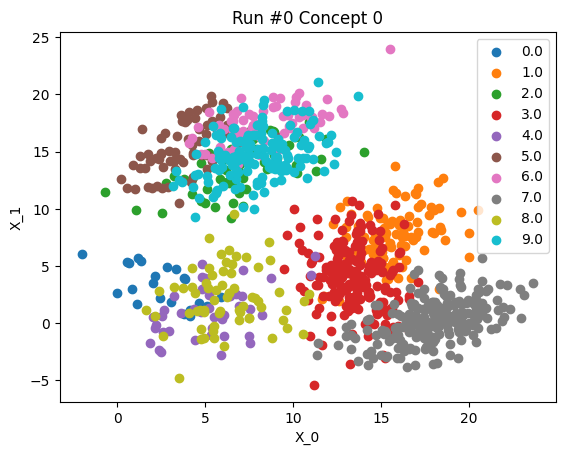

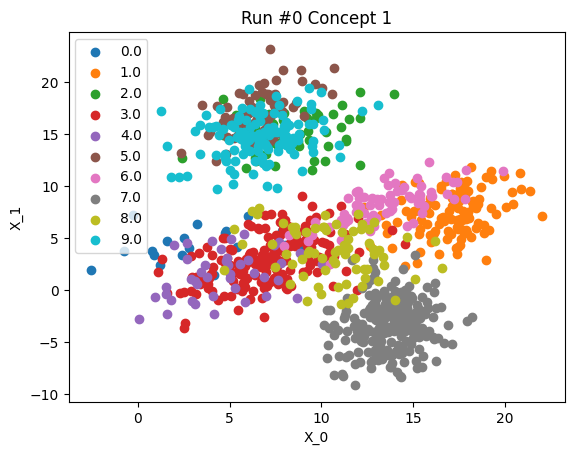

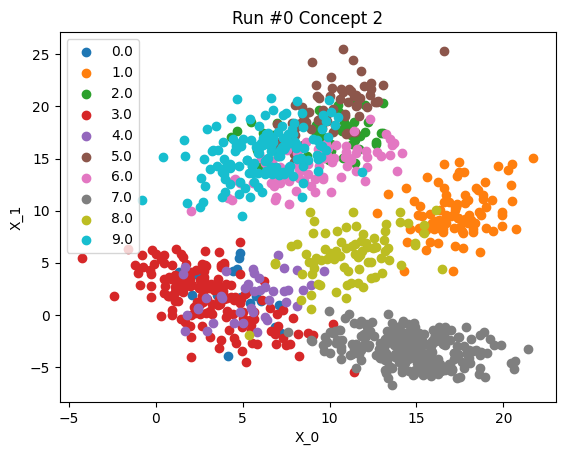

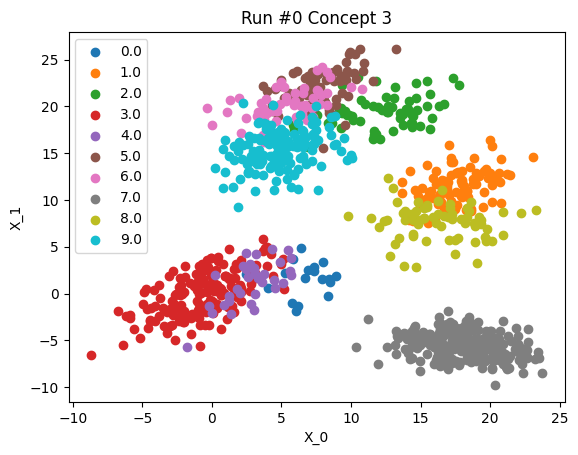

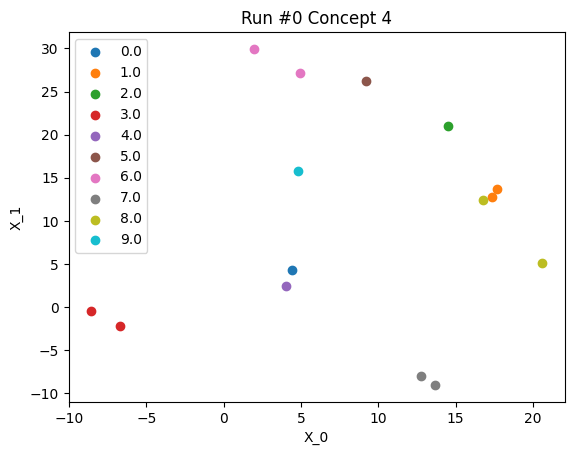

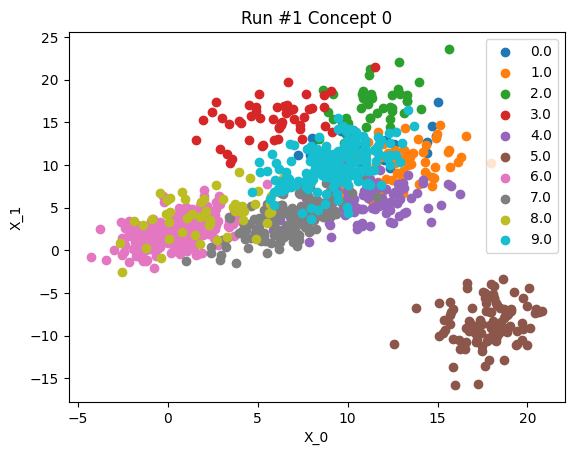

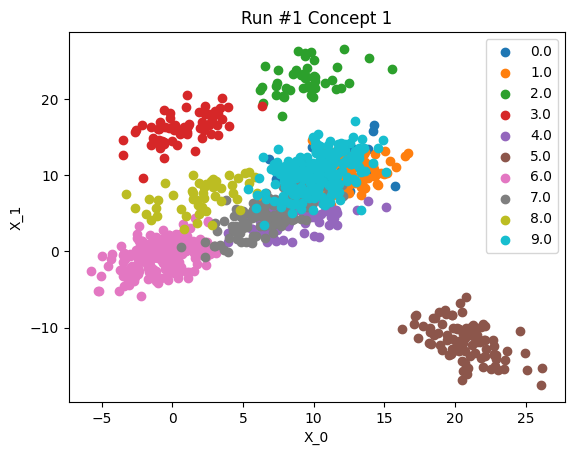

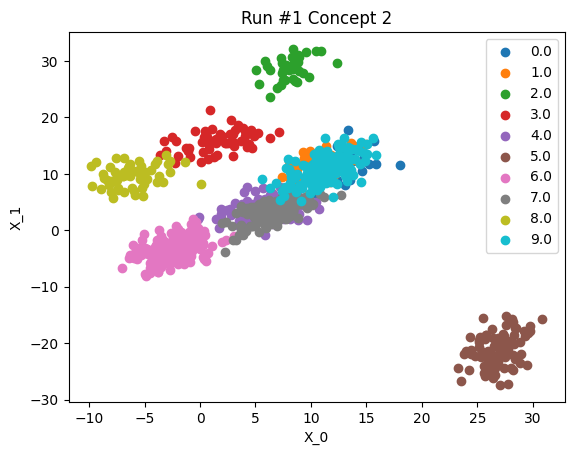

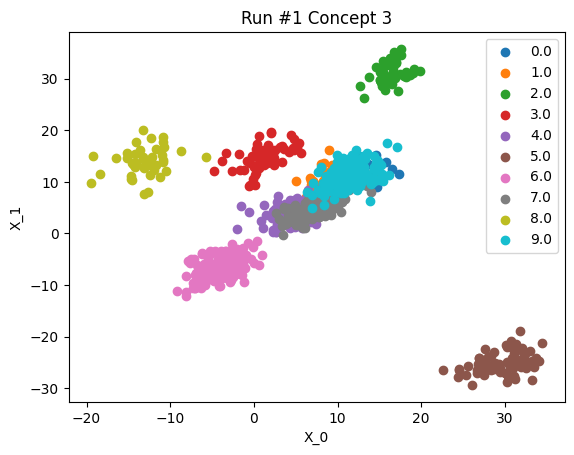

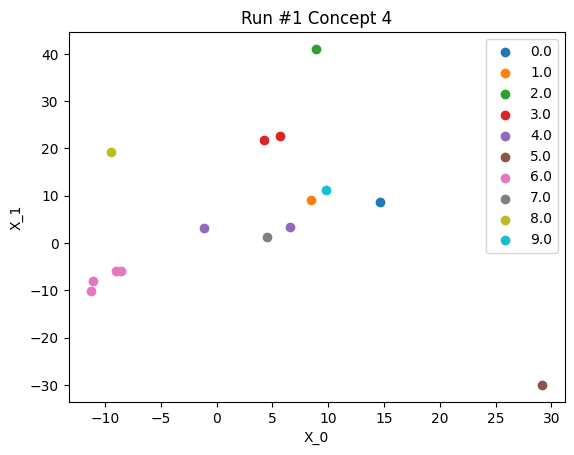

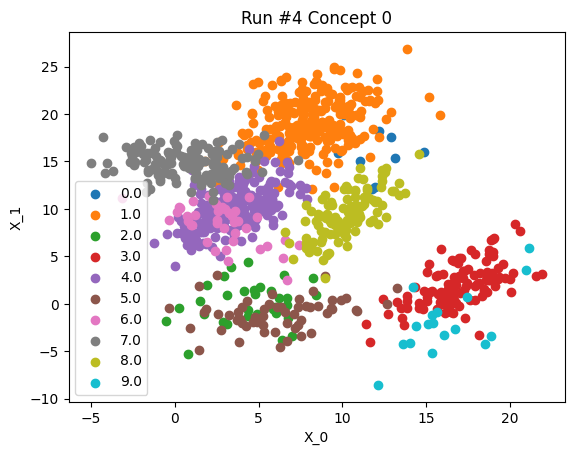

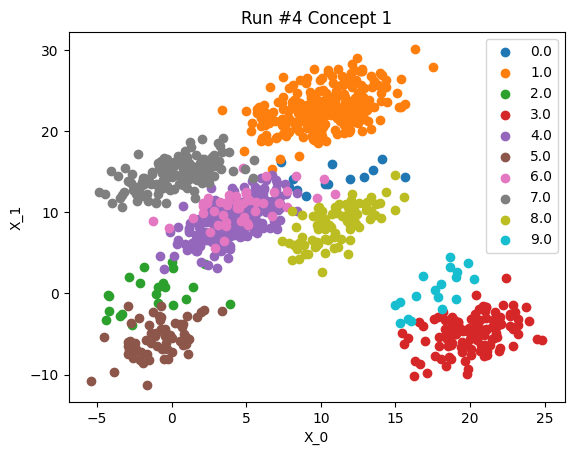

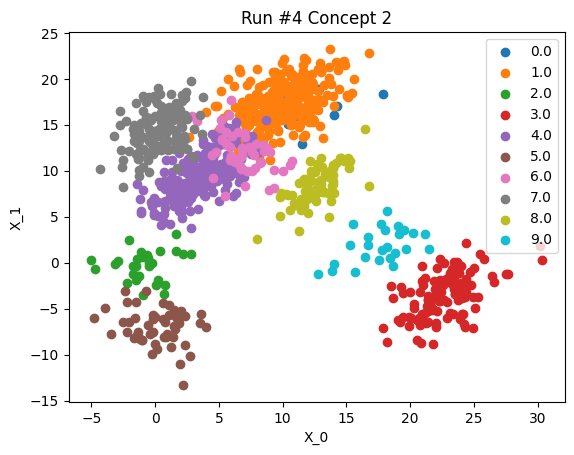

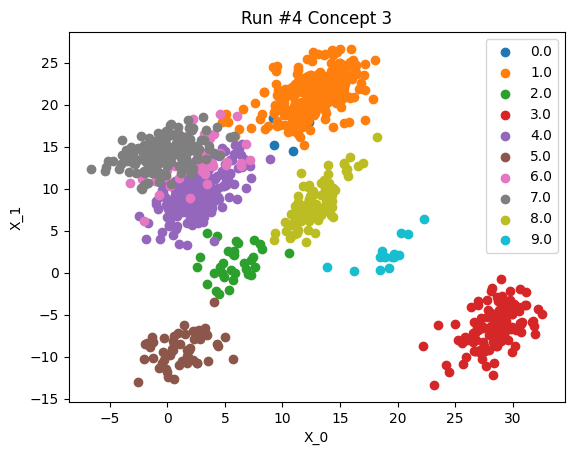

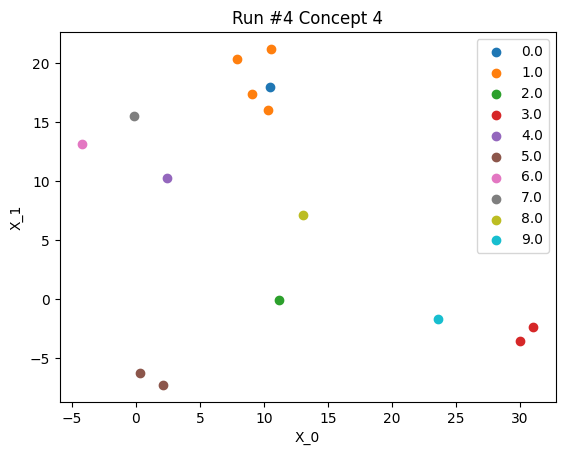

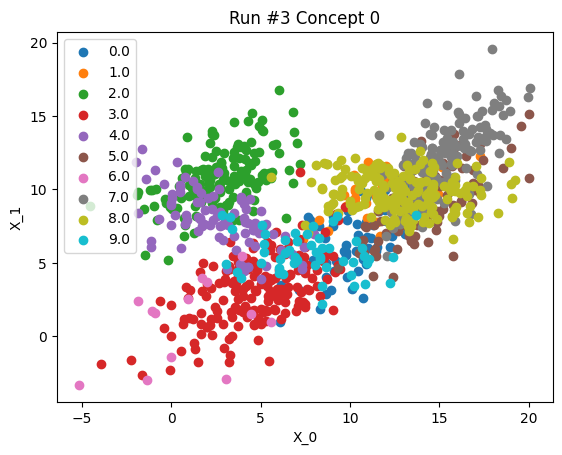

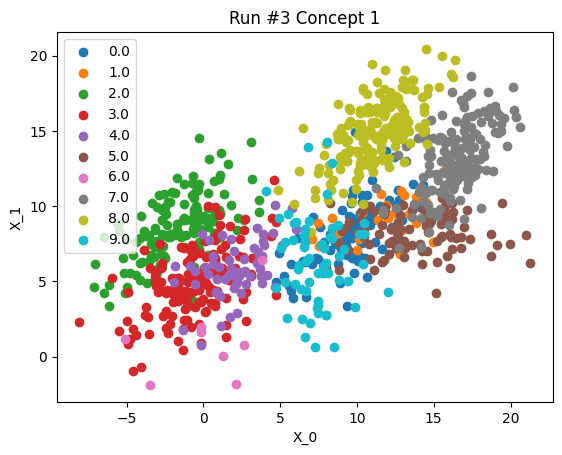

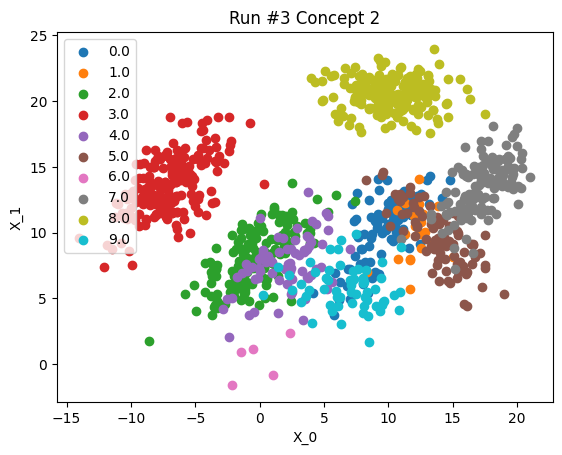

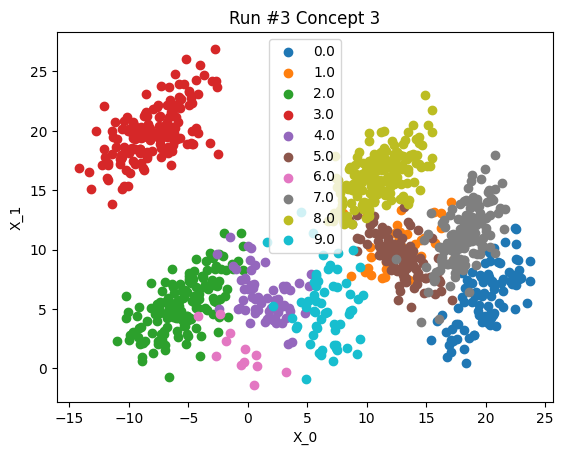

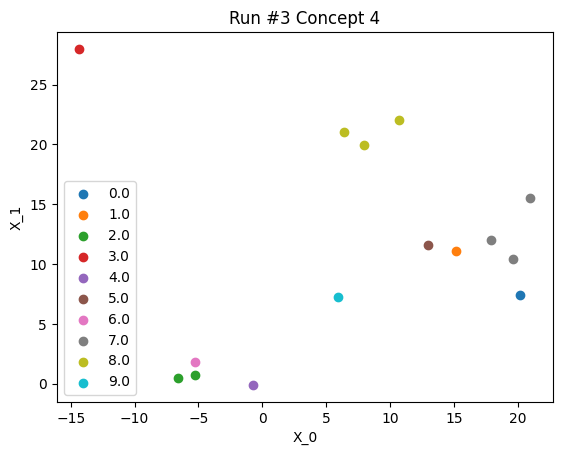

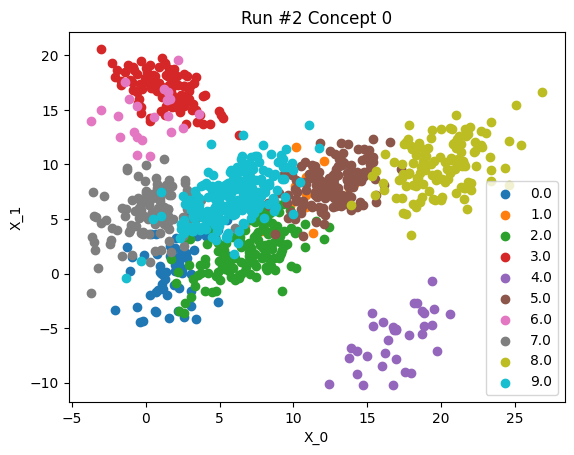

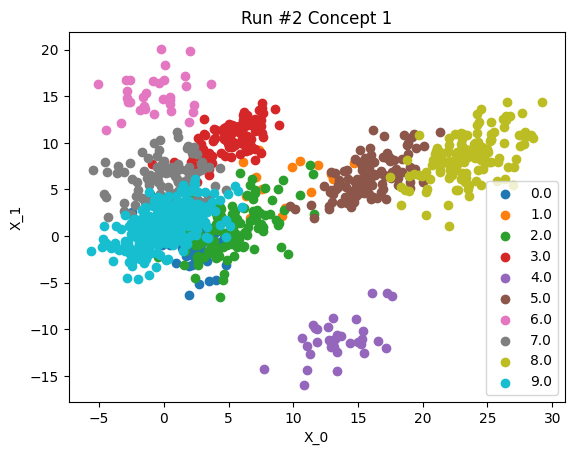

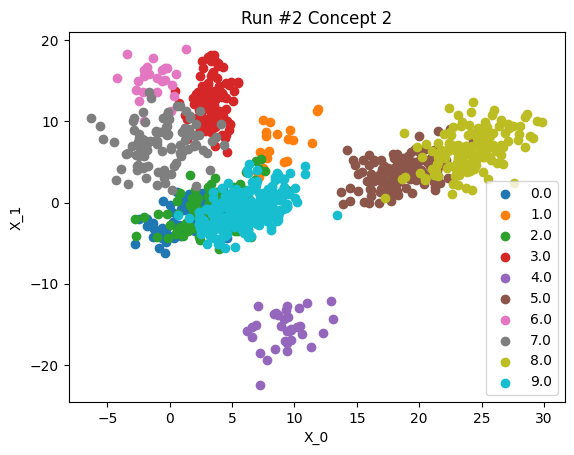

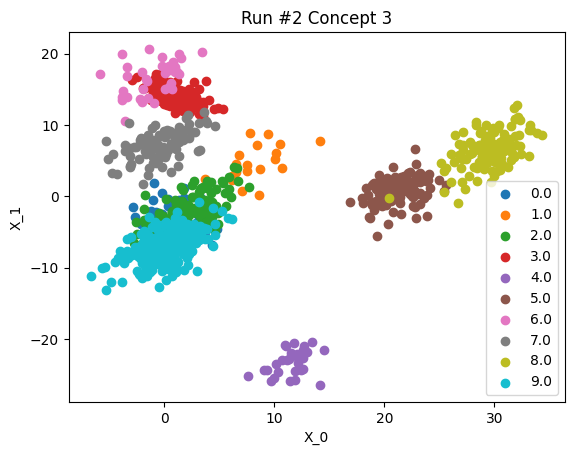

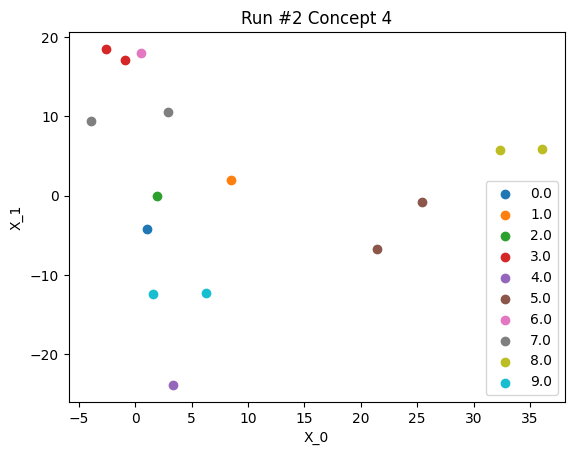

In [6]:
for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                    label=label)
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()

### Computing mean and std accuracy

In [7]:
mean_pre_AL_accuracy = np.mean(
    a=list(pre_AL_accuracy.values()),
    axis=0
)
mean_pre_AL_accuracy

0.7386666666666667

In [8]:
ws_accuracy = {}
for run in weighted_sampling_accuracy.keys():
    ws_accuracy[run] = []
    for key in weighted_sampling_accuracy[run].keys():
        ws_accuracy[run].append(weighted_sampling_accuracy[run][key])

In [9]:
rs_accuracy = {}
for run in random_sampling_accuracy.keys():
    rs_accuracy[run] = []
    for key in random_sampling_accuracy[run].keys():
        rs_accuracy[run].append(random_sampling_accuracy[run][key])

In [10]:
mean_ws_accuracy = np.mean(a=list(ws_accuracy.values()), axis=0)
mean_rs_accuracy = np.mean(a=list(rs_accuracy.values()), axis=0)

In [11]:
std_ws_accuracy = np.std(a=list(ws_accuracy.values()), axis=0)
std_rs_accuracy = np.std(a=list(rs_accuracy.values()), axis=0)

### Plot results

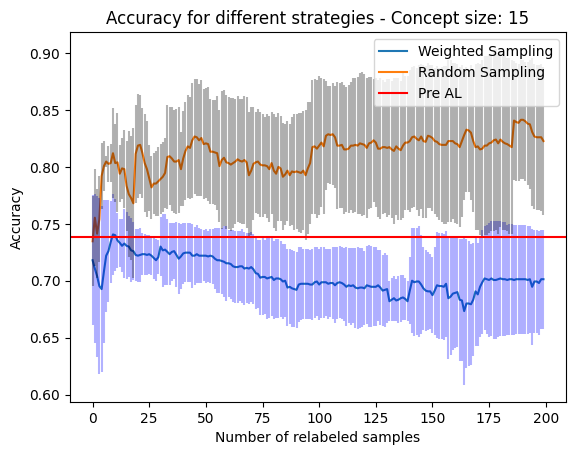

In [12]:
# create a new figure and axis object
fig, ax = plt.subplots()

# plot the accuracy values for each model as a line
ax.plot(list(range(len(mean_ws_accuracy))), list(mean_ws_accuracy), label='Weighted Sampling')
ax.plot(list(range(len(mean_rs_accuracy))), list(mean_rs_accuracy), label='Random Sampling')
ax.errorbar(list(range(len(mean_ws_accuracy))), list(mean_ws_accuracy), yerr=list(std_ws_accuracy), fmt='none', c='blue', alpha=0.3)
ax.errorbar(list(range(len(mean_rs_accuracy))), list(mean_rs_accuracy), yerr=list(std_rs_accuracy), fmt='none', c='black', alpha=0.3)
plt.axhline(y=mean_pre_AL_accuracy, color='r', linestyle='-', label='Pre AL')

# add a legend to the plot
ax.legend()

# set the x-axis label
ax.set_xlabel('Number of relabeled samples')

# set the y-axis label
ax.set_ylabel('Accuracy')

# set the title of the plot
ax.set_title('Accuracy for different strategies - Concept size: ' + str(metadata[runs_dirs[0]]['last_concept_size']))

# display the plot

plt.show()

### Plot Selected Samples

In [13]:
pd.set_option('display.max_rows', None)

In [14]:
unmatched_samples = deepcopy(ws_selected_samples)

In [15]:
for (run, concept_list) in concept_list_dict.items():
    for concept in concept_list:
        unmatched_samples[run] = pd.merge(unmatched_samples[run], concept, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [16]:
# useful to know how many samples have been relabeled with a different label
# from the original one when applying change to the select samples methods
len(unmatched_samples)

5

In [20]:
import matplotlib.colors as mcolors

color_cycle = mcolors.TABLEAU_COLORS  # You can choose any color set here
color_names = list(color_cycle.keys())

n_classes = 10 # change by importing it from metadata

color_list = [color_cycle[color_names[i]] for i in range(n_classes)]

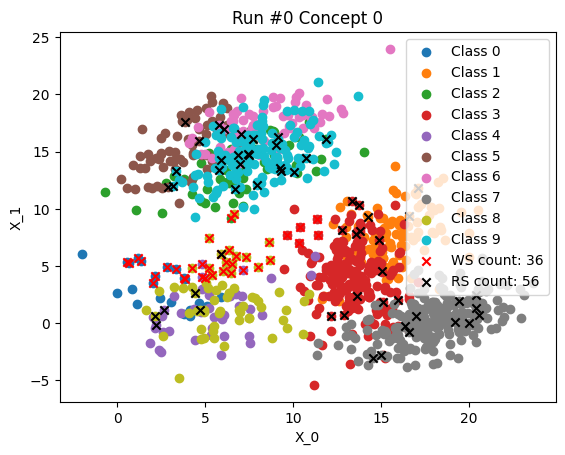

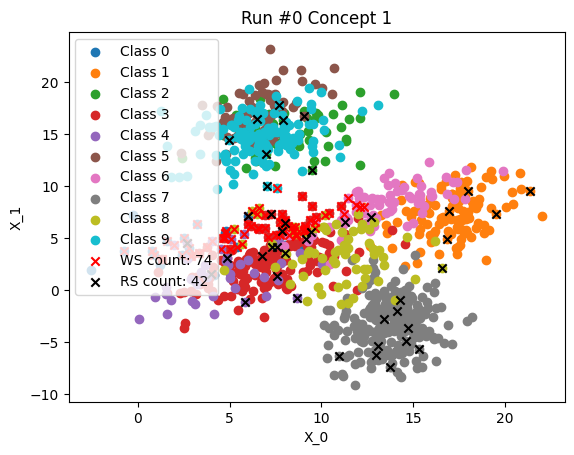

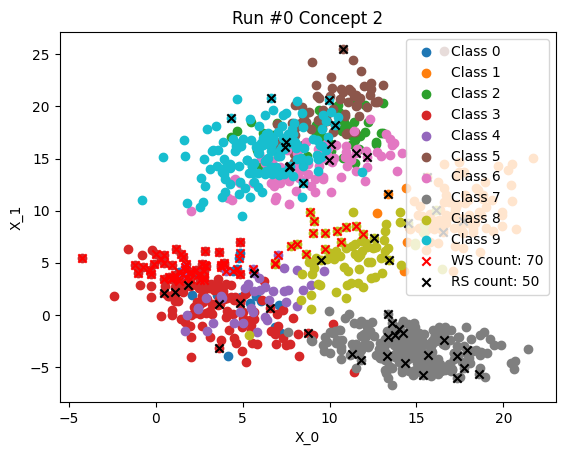

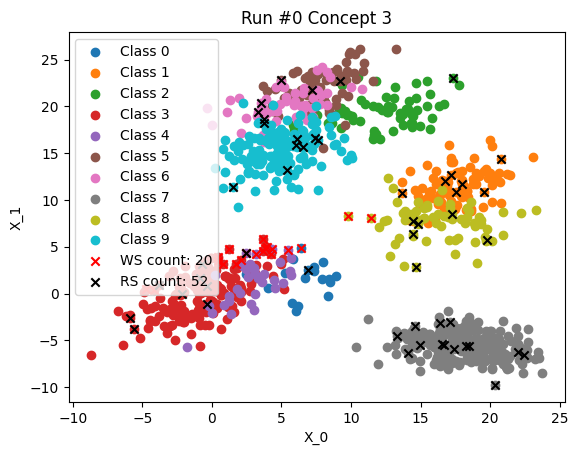

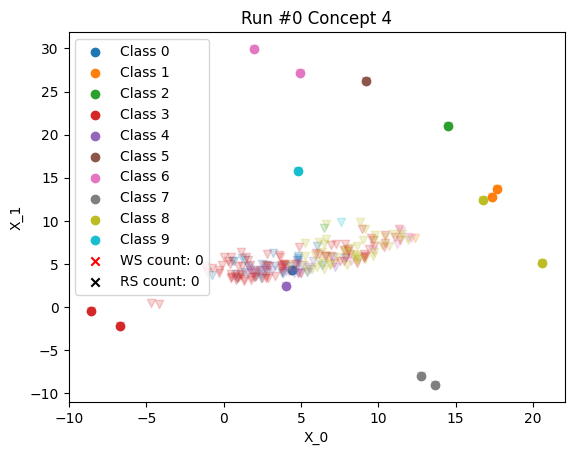

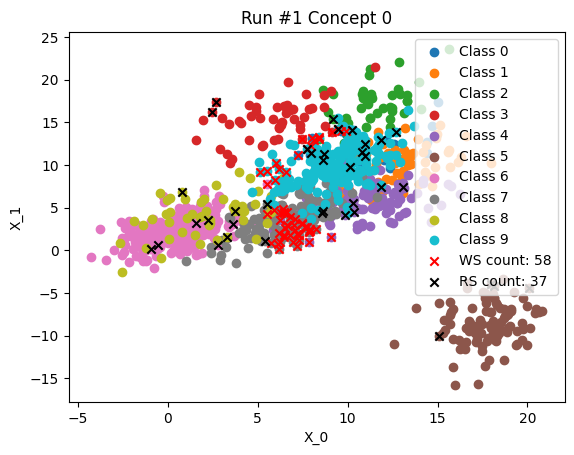

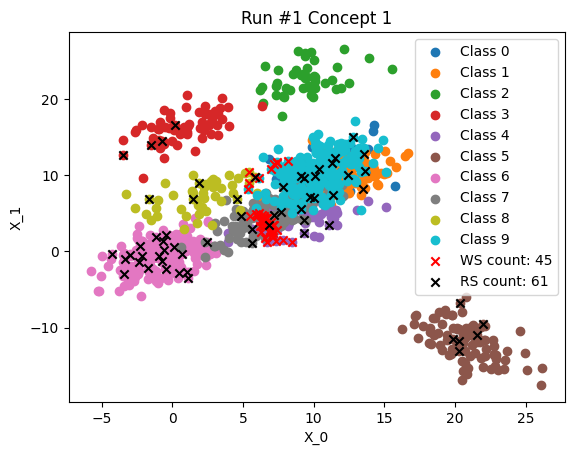

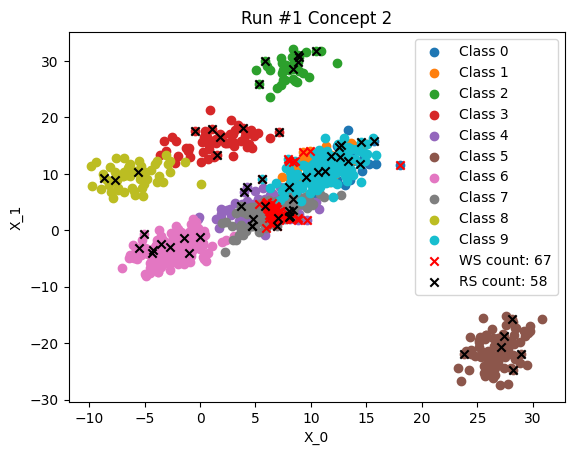

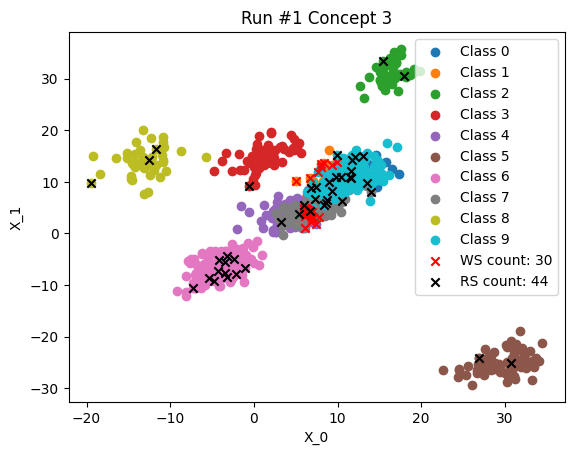

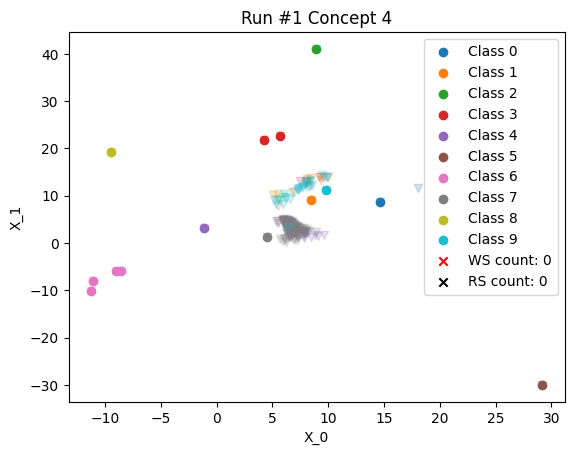

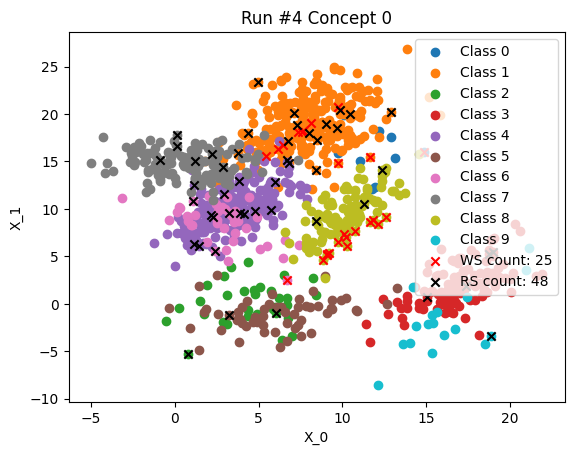

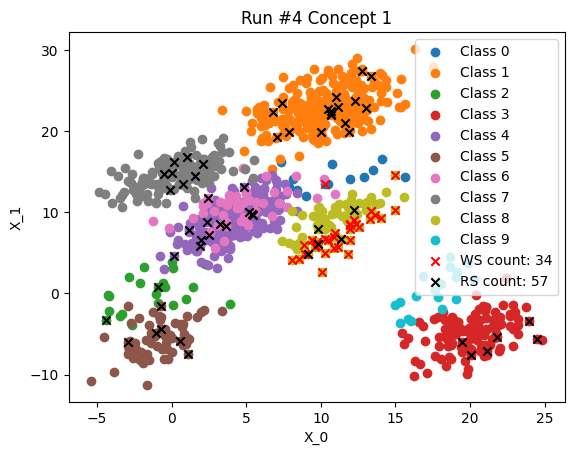

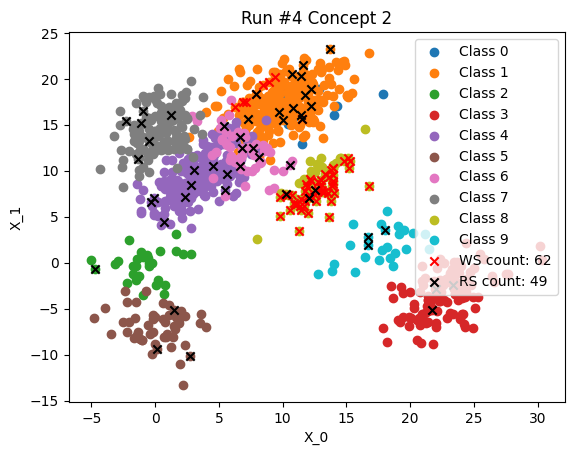

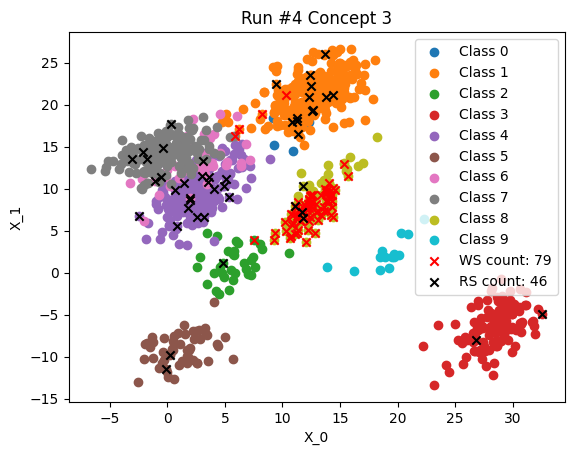

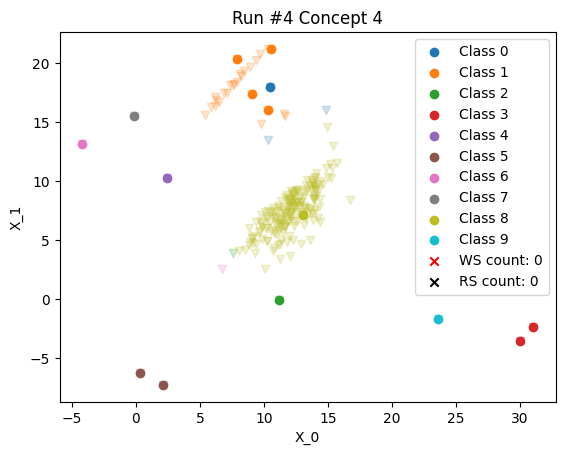

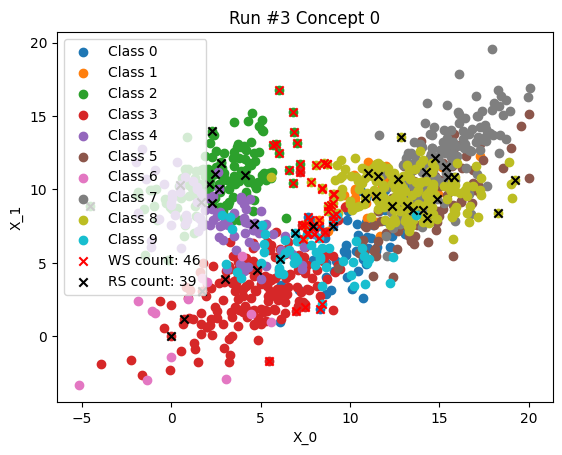

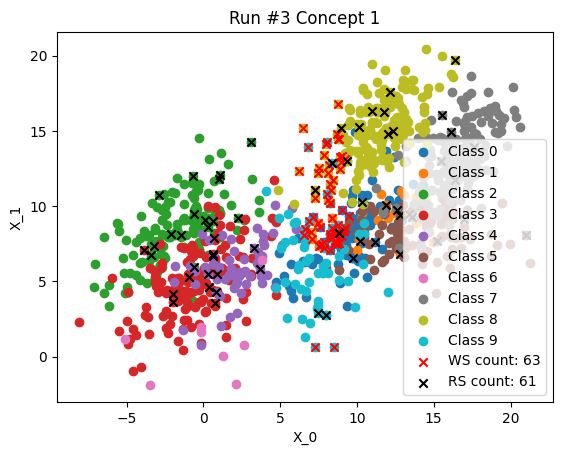

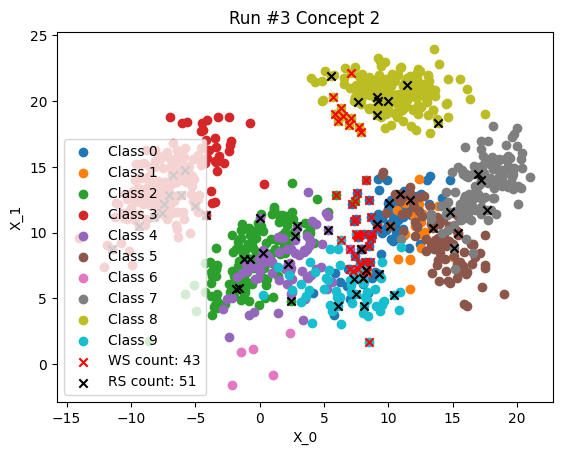

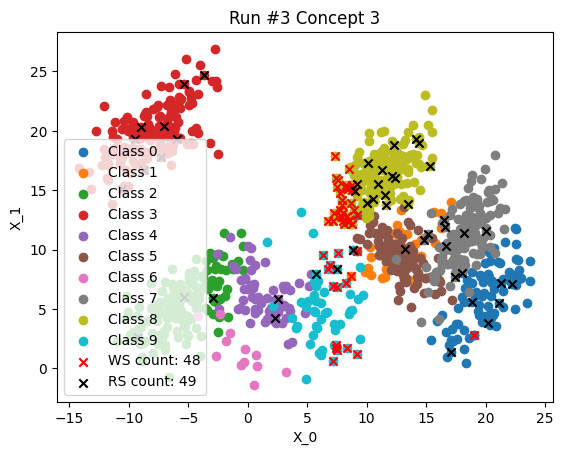

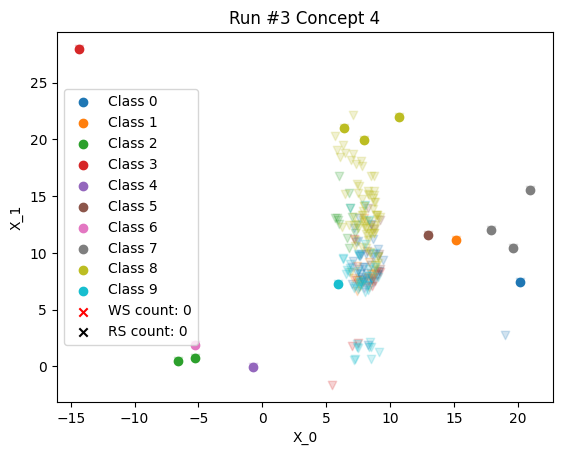

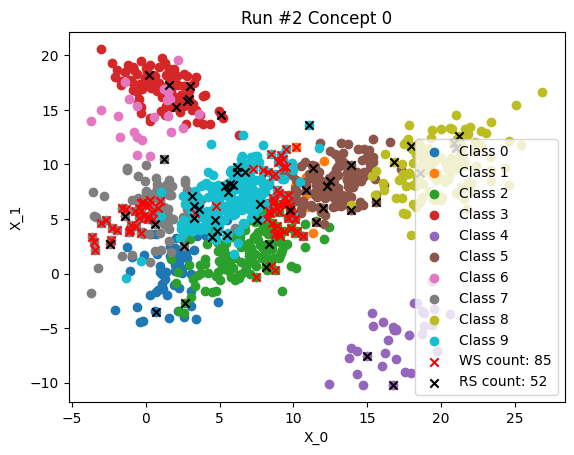

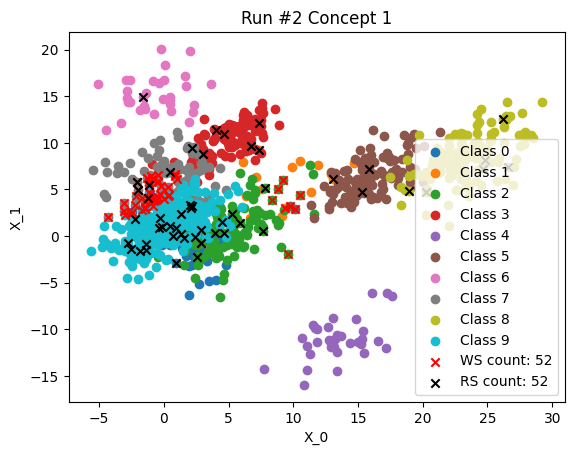

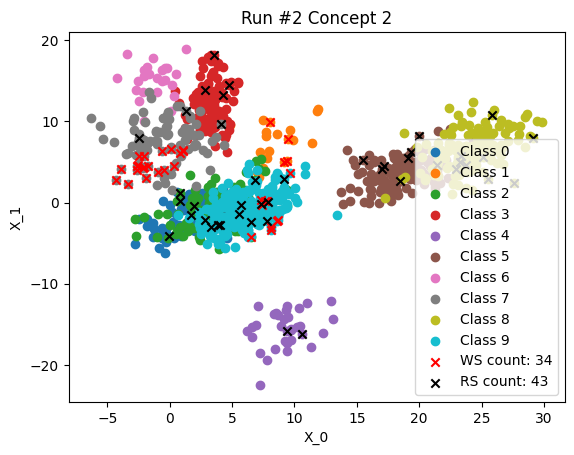

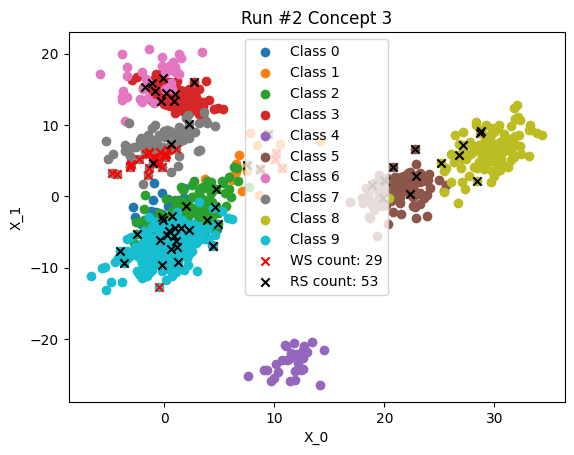

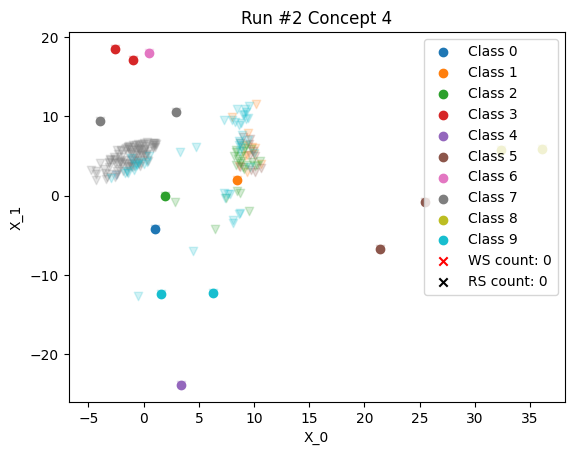

In [31]:
for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        selected_samples_ws = pd.merge(concept, ws_selected_samples[run])
        selected_samples_rs = pd.merge(concept, rs_selected_samples[run])

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                    label='Class ' + str(int(label)), color=color_list[int(label)])

            if index == len(concept_list) - 1:
                class_samples = ws_selected_samples[run].loc[ws_selected_samples[run]['y_0'] == label]
                selected_samples = pd.concat([group, class_samples], axis=0)
                ax.scatter(selected_samples['X_0'], selected_samples['X_1'], color=color_list[int(label)], alpha=0.2, marker='v')

        plt.scatter(selected_samples_ws['X_0'], selected_samples_ws['X_1'], c='red', marker='x', label='WS count: ' + str(selected_samples_ws.value_counts().count()))
        plt.scatter(selected_samples_rs['X_0'], selected_samples_rs['X_1'], c='black', marker='x', label='RS count: ' + str(selected_samples_rs.value_counts().count()))
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()